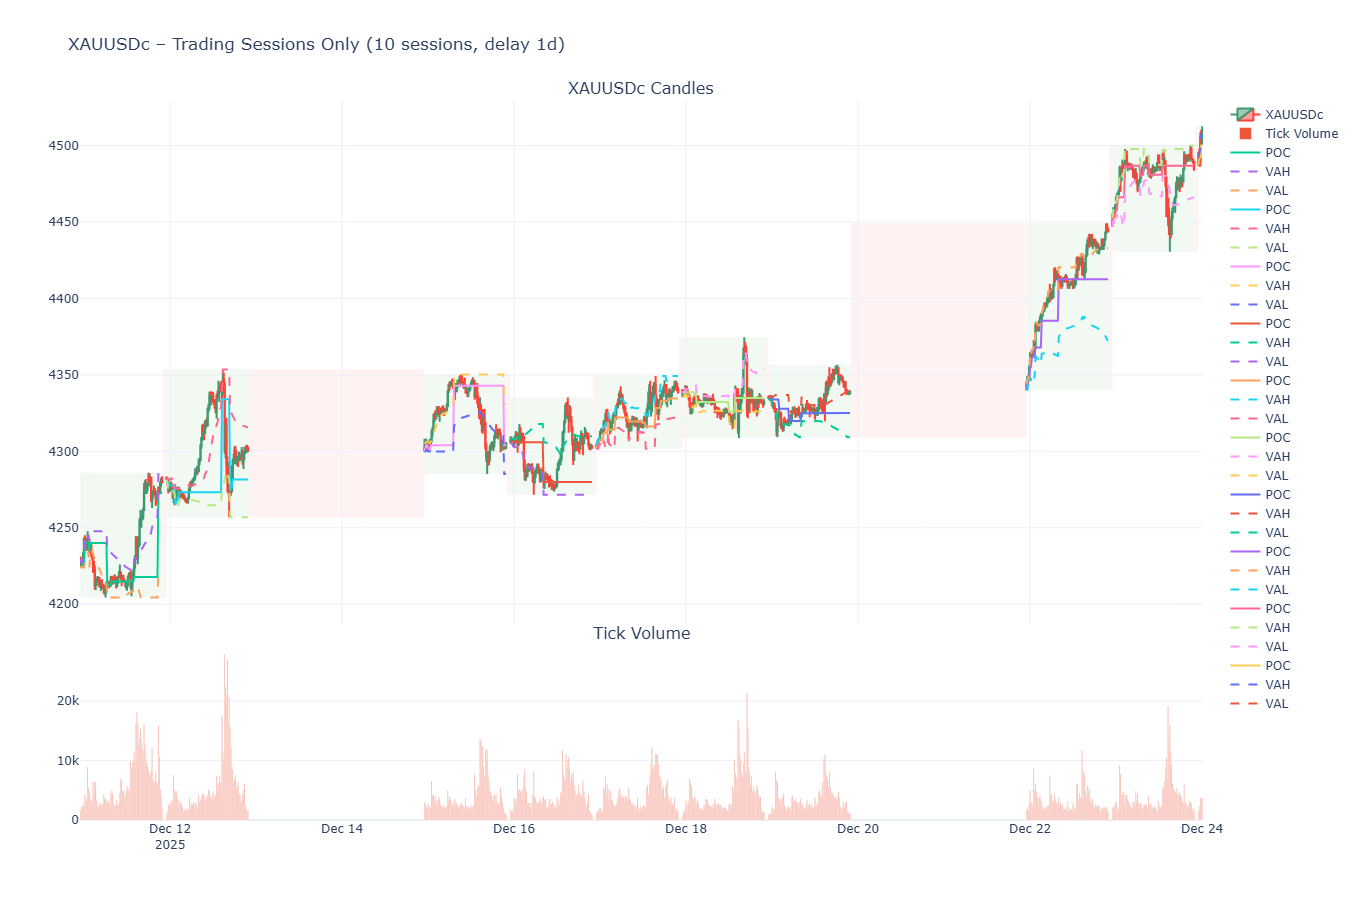

In [2]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# -------------------------------------------------
# PARAMETERS
# -------------------------------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M15
lookback_days = 10             # NUMBER OF TRADING SESSIONS
delay_days = 1
utc_timezone = pytz.UTC
value_area_pct = 0.7

# -------------------------------------------------
# HELPER: Convert MT5 timeframe to timedelta
# -------------------------------------------------
def timeframe_to_timedelta(tf):
    mapping = {
        mt5.TIMEFRAME_M1: timedelta(minutes=1),
        mt5.TIMEFRAME_M2: timedelta(minutes=2),
        mt5.TIMEFRAME_M3: timedelta(minutes=3),
        mt5.TIMEFRAME_M4: timedelta(minutes=4),
        mt5.TIMEFRAME_M5: timedelta(minutes=5),
        mt5.TIMEFRAME_M6: timedelta(minutes=6),
        mt5.TIMEFRAME_M10: timedelta(minutes=10),
        mt5.TIMEFRAME_M12: timedelta(minutes=12),
        mt5.TIMEFRAME_M15: timedelta(minutes=15),
        mt5.TIMEFRAME_M20: timedelta(minutes=20),
        mt5.TIMEFRAME_M30: timedelta(minutes=30),
        mt5.TIMEFRAME_H1: timedelta(hours=1),
        mt5.TIMEFRAME_H2: timedelta(hours=2),
        mt5.TIMEFRAME_H3: timedelta(hours=3),
        mt5.TIMEFRAME_H4: timedelta(hours=4),
        mt5.TIMEFRAME_H6: timedelta(hours=6),
        mt5.TIMEFRAME_H8: timedelta(hours=8),
        mt5.TIMEFRAME_H12: timedelta(hours=12),
        mt5.TIMEFRAME_D1: timedelta(days=1),
        mt5.TIMEFRAME_W1: timedelta(weeks=1),
        mt5.TIMEFRAME_MN1: timedelta(days=30),
    }
    return mapping.get(tf, timedelta(hours=1))

# -------------------------------------------------
# INITIALIZE MT5
# -------------------------------------------------
if not mt5.initialize():
    raise RuntimeError(mt5.last_error())

if not mt5.symbol_select(symbol, True):
    mt5.shutdown()
    raise RuntimeError(f"Symbol not available: {symbol}")

# -------------------------------------------------
# FETCH DATA (TRADING-DAY AWARE)
# -------------------------------------------------
utc_end = datetime.now(utc_timezone).replace(
    hour=0, minute=0, second=0, microsecond=0
) - timedelta(days=delay_days)

raw_from = utc_end - timedelta(days=lookback_days * 3)

rates = mt5.copy_rates_range(symbol, timeframe, raw_from, utc_end)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No data returned from MT5")

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)
df.set_index("time", inplace=True)
df.sort_index(inplace=True)

# -------------------------------------------------
# DETECT TRADING SESSIONS
# -------------------------------------------------
candle_delta = timeframe_to_timedelta(timeframe)
df["gap"] = df.index.to_series().diff() > candle_delta
df["session"] = df["gap"].cumsum()

# KEEP ONLY LAST N TRADING SESSIONS
last_sessions = df["session"].unique()[-lookback_days:]
df = df[df["session"].isin(last_sessions)]

# -------------------------------------------------
# BUILD SESSION + GAP STRUCTURES
# -------------------------------------------------
trading_sessions = []
non_trading_gaps = []

for _, group in df.groupby("session"):
    trading_sessions.append({
        "x0": group.index.min(),
        "x1": group.index.max() + candle_delta,
        "y0": group["low"].min(),
        "y1": group["high"].max(),
        "df": group
    })

for i in range(len(trading_sessions) - 1):
    gap_start = trading_sessions[i]["x1"]
    gap_end = trading_sessions[i + 1]["x0"]
    if gap_start < gap_end:
        non_trading_gaps.append({
            "x0": gap_start,
            "x1": gap_end,
            "y0": min(trading_sessions[i]["y0"], trading_sessions[i + 1]["y0"]),
            "y1": max(trading_sessions[i]["y1"], trading_sessions[i + 1]["y1"])
        })

# -------------------------------------------------
# PLOTLY FIGURE
# -------------------------------------------------
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.75, 0.25],
    subplot_titles=(f"{symbol} Candles", "Tick Volume")
)

fig.add_trace(
    go.Candlestick(
        x=df.index,
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name=symbol
    ),
    row=1,
    col=1
)

fig.add_trace(
    go.Bar(
        x=df.index,
        y=df["tick_volume"],
        name="Tick Volume"
    ),
    row=2,
    col=1
)

# -------------------------------------------------
# SESSION VISUALS
# -------------------------------------------------
for session in trading_sessions:
    fig.add_shape(
        type="rect",
        x0=session["x0"],
        x1=session["x1"],
        y0=session["y0"],
        y1=session["y1"],
        fillcolor="green",
        opacity=0.05,
        line=dict(width=0),
        layer="below"
    )

for gap in non_trading_gaps:
    fig.add_shape(
        type="rect",
        x0=gap["x0"],
        x1=gap["x1"],
        y0=gap["y0"],
        y1=gap["y1"],
        fillcolor="red",
        opacity=0.05,
        line=dict(width=0),
        layer="below"
    )

# -------------------------------------------------
# DEVELOPING POC / VAH / VAL
# -------------------------------------------------
for session in trading_sessions:
    sess_df = session["df"]
    cumulative_volume = {}

    poc_prices, vah_prices, val_prices, times = [], [], [], []

    for t, row in sess_df.iterrows():
        prices = np.arange(row["low"], row["high"] + 0.01, 0.10)
        vol = row["tick_volume"] / max(len(prices), 1)

        for p in prices:
            p = round(p, 2)
            cumulative_volume[p] = cumulative_volume.get(p, 0) + vol

        levels = np.array(sorted(cumulative_volume))
        vols = np.array([cumulative_volume[p] for p in levels])

        poc_idx = np.argmax(vols)
        poc_price = levels[poc_idx]

        target = vols.sum() * value_area_pct
        cum = vols[poc_idx]
        lo = hi = poc_idx

        while cum < target:
            if lo > 0:
                lo -= 1
                cum += vols[lo]
            if hi < len(vols) - 1:
                hi += 1
                cum += vols[hi]

        poc_prices.append(poc_price)
        vah_prices.append(levels[hi])
        val_prices.append(levels[lo])
        times.append(t)

    fig.add_trace(go.Scatter(x=times, y=poc_prices, mode="lines", line=dict(width=2), name="POC"), row=1, col=1)
    fig.add_trace(go.Scatter(x=times, y=vah_prices, mode="lines", line=dict(dash="dash"), name="VAH"), row=1, col=1)
    fig.add_trace(go.Scatter(x=times, y=val_prices, mode="lines", line=dict(dash="dash"), name="VAL"), row=1, col=1)

# -------------------------------------------------
# LAYOUT
# -------------------------------------------------
fig.update_layout(
    title=f"{symbol} – Trading Sessions Only ({lookback_days} sessions, delay {delay_days}d)",
    height=900,
    xaxis_rangeslider_visible=False,
    template="plotly_white"
)

fig.show()
